# Assignment1 PART B : FIT5202
### Submitted by : Hitesh Get
### Student ID : 29637333

### Step 01: Import pyspark and initialize Spark

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("MongoDB and Apache Spark Data Visualization")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/fit5202_db.assignment1_data")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/fit5202_db.assignment1_data")\
        .getOrCreate()

### Step 02: Create Dataframe

In [3]:
# Reading the csv file
crime_stats_df = spark.read.csv("Crime_Statistics_SA_2010_present.csv",header = True, inferSchema = True)

In [4]:
# Record count in the data frame
crime_stats_df.count()

727408

### Step 03: Write to Database

In [5]:
crime_stats_df = spark.read.csv("Crime_Statistics_SA_2010_present.csv",header = True, inferSchema = True)
crime_stats_df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

### Step 04: Read from Database

In [6]:
crime_mongodb_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
crime_mongodb_df.show(10)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            1|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5271|   13/07/2015|       NARACOORTE|[5d727a2a5bd48c0c...|
|            1|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5032|   18/06/2014|         LOCKLEYS|[5d727a2a5bd48c0c...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|                Other theft|               5032|   18/06/2014|  

In [7]:
crime_mongodb_df.columns

['Offence Count',
 'Offence Level 1 Description',
 'Offence Level 2 Description',
 'Offence Level 3 Description',
 'Postcode - Incident',
 'Reported Date',
 'Suburb - Incident',
 '_id']

### Step 05: Calculate the statistics of numeric and string columns

In [8]:
# Calculate the offence count statistics
crime_mongodb_df.select('Offence Count').describe().show()

+-------+------------------+
|summary|     Offence Count|
+-------+------------------+
|  count|            727407|
|   mean|1.1715174585892079|
| stddev|0.5787050930378105|
|    min|                 1|
|    max|                28|
+-------+------------------+



In [9]:
# Calculate the reported date statistics
crime_mongodb_df.select('Reported Date').describe().show()

+-------+-------------+
|summary|Reported Date|
+-------+-------------+
|  count|       727407|
|   mean|         null|
| stddev|         null|
|    min|    1/01/2011|
|    max|    9/12/2018|
+-------+-------------+



Here in the reported date we can see the minimum date is of 2011 but when we open the file and see the the min date if of year 2010.Also the maximum year calculated is 2018 but in the data file it is 2019 .this is because the the Reported date is string type instead of date type.

In [10]:
crime_mongodb_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 06: Change the data type of a column

In [11]:
# import all the libraries
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
from pyspark.sql.functions import *

In [12]:
# Change the reported date data type from string to date using udf
change_to_date =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())
crime_mongodb_df_new = crime_mongodb_df.withColumn('Reported Date', change_to_date(col('Reported Date')))
# Check the datatype of reported date
crime_mongodb_df_new.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 07: Preliminary data analysis

#### A.How many level 2 offences are there? Display the list of level 2 offences

In [13]:
# Removing the null values and counting offences
crime_mongodb_df_new.select('Offence Level 2 Description')\
.where(col("Offence Level 2 Description").isNotNull()).distinct().count()

9

In [14]:
# Displaying the list of level 2 offences
crime_mongodb_df_new.select('Offence Level 2 Description')\
.where(col("Offence Level 2 Description").isNotNull()).distinct().show()

+---------------------------+
|Offence Level 2 Description|
+---------------------------+
|       ROBBERY AND RELAT...|
|       PROPERTY DAMAGE A...|
|       SEXUAL ASSAULT AN...|
|       HOMICIDE AND RELA...|
|       ACTS INTENDED TO ...|
|       SERIOUS CRIMINAL ...|
|       OTHER OFFENCES AG...|
|       FRAUD DECEPTION A...|
|       THEFT AND RELATED...|
+---------------------------+



#### B.What is the number of offences against the person?

In [15]:
crime_mongodb_df_new.filter(col("Offence Level 1 Description") == 'OFFENCES AGAINST THE PERSON').\
groupby('Offence Level 1 Description').\
sum('Offence Count').show()

+---------------------------+------------------+
|Offence Level 1 Description|sum(Offence Count)|
+---------------------------+------------------+
|       OFFENCES AGAINST ...|            175644|
+---------------------------+------------------+



#### Calculating total number of offence, offences_against_person and offences_against_property

In [16]:
crimes_per_offence = crime_mongodb_df_new.groupby('Offence Level 1 Description').sum('Offence Count')

In [17]:
offences_against_person = crime_mongodb_df_new.filter(col("Offence Level 1 Description") == 'OFFENCES AGAINST THE PERSON')\
.groupby('Offence Level 1 Description').sum('Offence Count')\
.collect()[0][1]

In [18]:
offences_against_person

175644

In [19]:
offences_against_property = crime_mongodb_df_new.filter(col("Offence Level 1 Description") == 'OFFENCES AGAINST PROPERTY')\
.groupby('Offence Level 1 Description').sum('Offence Count')\
.collect()[0][1]

In [20]:
offences_against_property

676526

In [21]:
total_offences = crimes_per_offence.agg({'sum(Offence Count)':"sum"}).collect()[0][0]
total_offences

852170

#### C.How many serious criminal tresspasses with more than 1 offence count?

In [22]:
crime_mongodb_df_new.filter(col("Offence Level 2 Description") == 'SERIOUS CRIMINAL TRESPASS').\
filter(col("Offence Count") > 1).select('Offence Level 2 Description').count()

8579

#### D.What percentage of crimes are offences against the property?

In [23]:
percentage_crime_against_property = (offences_against_property/total_offences)*100
percentage_crime_against_property

79.3886196416208

In [24]:
crime_mongodb_df_new.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 08: Exploratory data analysis

#### A. Number of Crimes Per Year

In [25]:
# Create a dataframe consisting reported date and offence count
df_reported_year = crime_mongodb_df.select('Reported Date','Offence Count')
# Extracting year from the reported date
df_reported_year = df_reported_year.withColumn('Reported_Year',year(to_timestamp('Reported Date', 'dd/MM/yyyy')))

In [26]:
# Manipulating the dataframe
df_reported_year = df_reported_year.groupby('Reported_Year').sum('Offence Count').orderBy('Reported_Year').dropna()
df_reported_year_list = df_reported_year.collect()


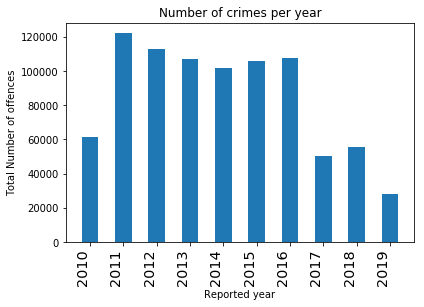

In [27]:
# Creating total offence variable for an year
total_offence = [row['sum(Offence Count)'] for row in df_reported_year_list ]
# Creating Offence reported year
Reported_year = [row['Reported_Year'] for row in df_reported_year_list ] 
bar_width = 0.5
# Creating the index
index = np.arange(len(Reported_year))
# Plotting the bar graph
plt.bar(index, total_offence, bar_width, align='center')
plt.xticks(index,Reported_year)
plt.xlabel('Reported year')
plt.ylabel('Total Number of offences')
plt.title('Number of crimes per year')
plt.tight_layout()
plt.xticks( rotation=90,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

Here as per the graph we can see that the rate of crime increased from 2010 and then gradually decreased reaching minimum in 2019.

#### B. Number of Crimes Per Month

In [28]:
# Create a dataframe consisting reported date and offence count
df_reported_month = crime_mongodb_df.select('Reported Date','Offence Count')
# Extracting the month value from the reported date
df_reported_month = df_reported_month.withColumn('reported_month',month(to_timestamp('Reported Date', 'dd/MM/yyyy')))
df_reported_month = df_reported_month.groupby('reported_month').sum('Offence Count').orderBy('reported_month').dropna()
df_month_list = df_reported_month.collect()

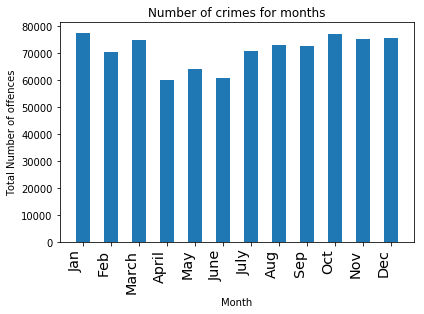

In [29]:
# Creating total offence variable for an year
total_offence = [row['sum(Offence Count)'] for row in df_month_list ]
# Creating the month list for all the months
month_list = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec'] 
bar_width = 0.5
# Creating the index for bar graph
index = np.arange(len(month_list))
# Plot the bar graph
plt.bar(index, total_offence, bar_width, align='center')
plt.xticks(index,month_list)
plt.xlabel('Month')
plt.ylabel('Total Number of offences')
plt.title('Number of crimes for months')
plt.tight_layout()
plt.xticks( rotation=90,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

Here as per the graph,maximum crime was in January the crime rates has dropped for the month of April till june and then again gradually increased till oct, reaching saturation in december

#### C.Where do most crimes take place? 

In [30]:
# Creating the suburb dataframe
df_suburb = crime_mongodb_df.select(concat(col("Suburb - Incident"), lit("-"), col("Postcode - Incident"))\
                                        .alias("Postcode"),'Offence Count')

In [31]:
df_suburb.columns

['Postcode', 'Offence Count']

In [32]:
# Manipulate the suburb dataset
df_suburb = df_suburb.groupby('Postcode').sum('Offence Count')

In [33]:
# Sort the sururbs on the basis of offence count
df_suburb = df_suburb.sort('sum(Offence Count)',ascending = False)

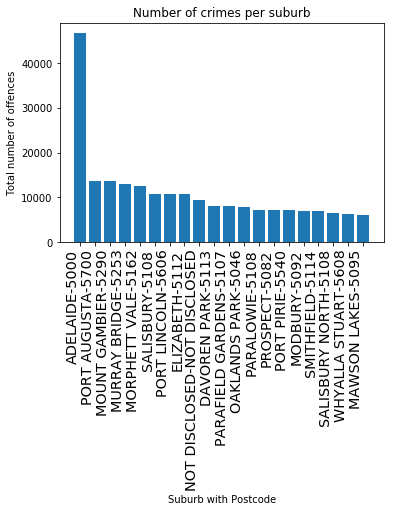

In [34]:
# Take the top 20 suburbs
df_suburb_list = df_suburb.take(20)
# Calculate total offence count
total_offence = [row['sum(Offence Count)'] for row in df_suburb_list]
# Collect the suburb information from the suburb list
suburb = [row['Postcode'] for row in df_suburb_list] 
bar_width = 0.5
# Plot the graph
index = np.arange(len(suburb))
plt.bar(index, total_offence, align='center')
plt.xticks(index,suburb)
plt.xlabel('Suburb with Postcode')
plt.ylabel('Total number of offences')
plt.title('Number of crimes per suburb')
plt.tight_layout()
plt.xticks( rotation=90,horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

Here the graph indicates that the crime rate is too high in citiessuch as Adelaide as compared to the suburbs which are small and less densly populated.

#### Find the number of serious criminal trespasses by day and month

In [35]:
# Creating the data frame for reported date and offence count for serious criminal trespass
df_day_of_month = crime_mongodb_df.filter(col('Offence Level 2 Description') == 'SERIOUS CRIMINAL TRESPASS')\
.select('Reported Date','Offence Count')
# Extracting the day and month from the reported date
df_day_of_month = df_day_of_month.withColumn('reported_month',month(to_timestamp('Reported Date', 'dd/MM/yyyy')))
df_day_of_month = df_day_of_month.withColumn('reported_day',dayofweek(to_timestamp('Reported Date', 'dd/MM/yyyy')))


In [36]:
df_day_of_month1 = df_day_of_month.groupby(['reported_month','reported_day']).sum('Offence Count')\
.orderBy(['reported_month','reported_day']).dropna()
day_month_list = df_day_of_month1.collect()

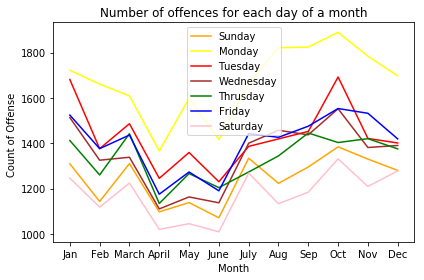

In [37]:
# Create the weekday from the day month list and assign sum of offence count
Sun = [row['sum(Offence Count)'] for row in day_month_list if row['reported_day'] == 1]
Mon = [row['sum(Offence Count)'] for row in day_month_list if row['reported_day'] == 2]
Tue = [row['sum(Offence Count)'] for row in day_month_list if row['reported_day'] == 3]
Wed = [row['sum(Offence Count)'] for row in day_month_list if row['reported_day'] == 4]
Thu = [row['sum(Offence Count)'] for row in day_month_list if row['reported_day'] == 5]
Fri = [row['sum(Offence Count)'] for row in day_month_list if row['reported_day'] == 6]
Sat = [row['sum(Offence Count)'] for row in day_month_list if row['reported_day'] == 7]
# Create month value list
month_value = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec'] 
y_pos = np.arange(len(month_value))
# Plot the graph
bar_width = 0.5
plt.plot(month_value, Sun, color='orange')
plt.plot(month_value, Mon, color='yellow')
plt.plot(month_value, Tue, color='red')
plt.plot(month_value, Wed, color='brown')
plt.plot(month_value, Thu, color='green')
plt.plot(month_value, Fri, color='blue')
plt.plot(month_value, Sat, color='pink')
plt.xlabel('Month')
plt.ylabel('Count of Offense ')
plt.legend(['Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday'])
plt.title('Number of offences for each day of a month')
plt.tight_layout()
plt.show()

From the graph, we can conclude that the serious criminal trespasses reported fluctuated maximum on a Monday and minimum on Saturday. Rest of the days the reported serious criminal trespasses fluctuations were not that drastic.